In [1]:
def read_RENISHAW_2D_wdf(file, lbd_dep = None, lbd_end = None ):

    '''
    Read a Raman hyperspectra stored in .wdf (RENISHAW format)
    base on the package renishawWiRE

    Arguments:
      file (string): name of the file containing the hyperspectra
      lbd_dep (real): first wavelength [cm-1] (default = None)
      led_end (real): end wavelength [cm-1] (default = None)

    Returns:
      da (xarray): full spectrum
      da_interp (xarray): full spectrum interpollated on a regular grid
      da_sliced (xarray): sliced spectrum between ldb_dep and lbd_end
      da_sliced_interp (xarray): sliced spectrum between ldb_dep and lbd_end interpollated on a constant grid

    '''
    
    #3rd party dependencies
    import numpy as np
    import pandas as pd
    import renishawWiRE as wire
    from renishawWiRE import types
    import raman_hyperspectra as rhp

    if not file.lower().endswith('.wdf'):
        raise Exception('not a .wdf file')

    data = wire.WDFReader(file, quiet = True)
    lbd = data.xdata[::-1]

    if not lbd_dep : lbd_dep = lbd[0]
    if not lbd_end : lbd_end = lbd[-1]

    assert lbd_end > lbd_dep , 'lbd_dep must be lower than lbd_end'

    x = np.unique(data.xpos)
    x -= x[0]
    y = np.unique(data.ypos)
    y -= y[0]
    spectrum = data.spectra

    da = rhp.construct_xarray(spectrum ,
                          y,
                          x,
                          lbd,
                          units = 'µm', 
                          tool = 'RENISHAW')

    lbd_interp = np.arange(da.lbd.values[0], da.lbd.values[-1], min(np.diff(da.lbd.values)))
    da_interp = da.interp(lbd = lbd_interp, method='cubic')
    da_interp.lbd.attrs['spectral_resolution'] = min(np.diff(da.lbd.values))
    da_interp.lbd.attrs['units'] = 'cm-1'

    da_sliced = da.sel(lbd = slice(lbd_dep, lbd_end))
    da_sliced.lbd.attrs['spectral_resolution'] = np.mean(np.diff(da_sliced.lbd.values))

    lbd_interp = np.arange(da_sliced.lbd.values[0],da_sliced.lbd.values[-1],min(np.diff(da_sliced.lbd.values)))
    da_sliced_interp = da_sliced.interp(lbd = lbd_interp, method='cubic')
    da_sliced_interp.lbd.attrs['spectral_resolution'] = np.mean(np.diff(da_sliced_interp.lbd.values))
    da_sliced_interp.lbd.attrs['units'] = 'cm-1'

    return da_sliced, da_sliced_interp, da, da_interp

In [2]:
file = r'C:\Users\franc\OneDrive\Bureau\checck\spectra_files\mapping.wdf'
da_sliced, da_sliced_interp, da, da_interp = read_RENISHAW_2D_wdf(file)

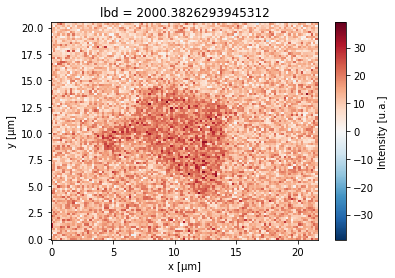

In [6]:
da_sliced_interp.sel(lbd = 2000, method= 'nearest').plot()

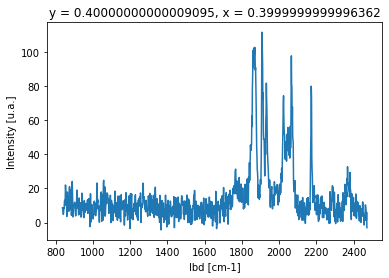

In [5]:
da_sliced_interp.sel(x = 0.4, y = 0.3, method= 'nearest').plot()